In [1]:
import sys
sys.path.append('/Users/balazstorok/SCIENCE/Projects/BMLLab/bart/python/')
import bart
import numpy as np

from pystan import StanModel
import pickle
sm = pickle.load(open('/Users/balazstorok/SCIENCE/Projects/BMLLab/bart/python/model_3_softmax.pkl','rb'))

In [2]:
n = 2
i_max = 70
N_balloons = 30
rewards = np.array([2*i for i in range(i_max)])
chains = 2
iterations = 400
true_values = []

seed = 201
np.random.seed(seed = seed)

for i in range(n):
    m0 = np.exp(np.random.normal(3,1))
    true_values.append(dict(m0 = m0,
                            a0 = m0+np.exp(np.random.normal(3,1)),
                            gamma_pos = np.random.normal(1,0.2),
                            beta = np.random.normal(10,3),
                            i_max = i_max,
                            rewards = rewards,
                            p_pop = np.repeat(np.random.beta(2,20),i_max), 
                            n = N_balloons))

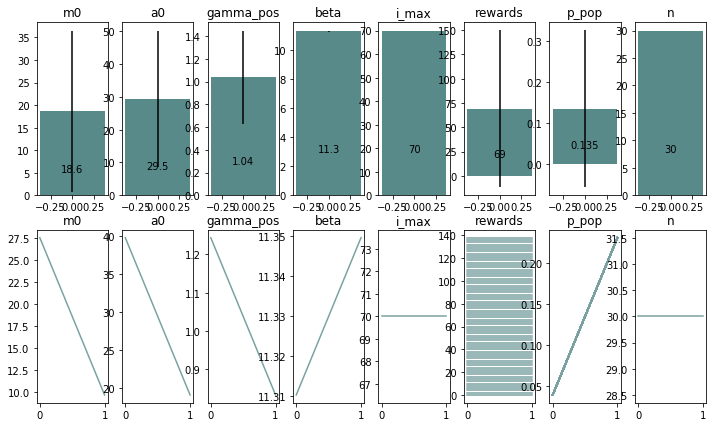

In [3]:
import stan_plots as s_p
import importlib
importlib.reload(s_p)
base_params = dict()
for key, values in true_values[0].items():
    base_params[key] = [t[key] for t in true_values]
s_p.sample_plots(base_params, 1)

In [4]:
from wurlitzer import sys_pipes
seed = 123

samples_list = []
players, experiments = [], []
def format_data_for_stan(data):
    dat = dict(N = len(data),
               pumps = [d['pumps']+1 for d in data],
               popped = [int(d['popped']) for d in data],
               )
    return(dat)

for params in true_values:
    players.append(bart.Model_3_softmax(a0 = params['a0'],
                                        m0 = params['m0'],
                                        beta = params['beta'],
                                        gamma = params['gamma_pos'],
                                        i_max = params['i_max'],
                                        ))
    experiments.append(bart.Experiment(player = players[-1], 
                                       p_pop = params['p_pop'], 
                                       rewards = params['rewards'],
                                       n = params['n']))
    wallet = experiments[-1].run_artificial()
    data = format_data_for_stan(experiments[-1].get_data())
    data['i_max'] = params['i_max']
    data['rewards'] = params['rewards']

    with sys_pipes():
        iterations = 400
        chains = 2
        fit = sm.sampling(data = data, 
                          iter = iterations,
                          chains = chains,
                          seed = seed)
        samples_list.append(fit.extract())

Balloon banked at:  2
Balloon banked at:  3
Balloon banked at:  3
Balloon banked at:  2
Balloon banked at:  3
Balloon banked at:  4
Balloon banked at:  3
Balloon banked at:  3
Balloon banked at:  2
Balloon popped at:  1
Balloon popped at:  2
Balloon banked at:  3
Balloon banked at:  4
Balloon popped at:  1
Balloon popped at:  2
Balloon banked at:  3
Balloon banked at:  3
Balloon banked at:  3
Balloon banked at:  3
Balloon popped at:  3
Balloon banked at:  5
Balloon banked at:  4
Balloon banked at:  3
Balloon banked at:  5
Balloon banked at:  5
Balloon banked at:  5
Balloon popped at:  5
Balloon banked at:  3
Balloon banked at:  5
Balloon banked at:  5

Gradient evaluation took 0.006996 seconds
1000 transitions using 10 leapfrog steps per transition would take 69.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00685 seconds
1000 transitions using 10 leapfrog steps per transition would take 68.5 seconds.
Adjust your expectations accordingly!


Iteration:  

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: categorical_logit_lpmf: log odds parameter[1] is nan, but must be finite!  (in 'unknown file name' at line 61)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: categorical_logit_lpmf: log odds parameter[1] is nan, but must be finite!  (in 'unknown file name' at line 61)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis prop

In [ ]:
def parameter_recovery_plot(samples_list):
    fig, ax = plt.subplots(1, len(samples_list[0]))
    c = 0
    for key, value in samples_list[0]:
        ax[0,c].plot([min([t[key] for t in true_values]),
                      max([t[key] for t in true_values])],
                     [min([t[key] for t in true_values]),
                      max([t[key] for t in true_values])])
        ax[0,c].set_title(key)
        c += 1
    for i, samples in enumerate(samples_list):
        c = 0
        for key, value in samples.items():
            ax[0,c].scatter(x = true_values[i][key], y = np.mean(samples[key]), yerr = np.std(samples[key]))
            c += 1


parameter_recovery_plot(samples_list)